# Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import json
import csv

%matplotlib widget
plt.rc('text', usetex = True)
plt.rcParams['figure.facecolor'] = 'w'
# plt.rcParams['figure.figsize'] = [10.0, 6.0]
# plt.rcParams['font.size'] = 16
plt.style.use('classic')

# Load data

In [2]:
WinMat = "Be"

path = f"/Users/max/SLAC Fall 2024/LXeSims/{WinMat}_sigmaR_3mm_thickness_0.5mm"
# path = '/Users/max/SLAC Fall 2024/LXeSims/Geant4_test'

cols = 'x y z Px Py Pz t PDGid EventID TrackID ParentID Weight Edep VisibleEdep Ntracks'.split(' ')

with open("../analysis/z_sim_info.json", "r") as f:
    info = json.load(f)
    
n_events = info["n_events"]

df_LXe = pd.read_csv(path+"/LXe.txt", skiprows=1, header=0, delim_whitespace=True, names=cols)

df_EntranceWin = pd.read_csv(path+"/WinIn.txt", skiprows=1, header=0, delim_whitespace=True, names=cols)
df_ExitWin = pd.read_csv(path+"/WinOut.txt", skiprows=1, header=0, delim_whitespace=True, names=cols)

# Electron charge in C
e_charge = 1.602176634e-19

# Material densities in g/cm^3 (https://www.fe.infn.it/u/paterno/Geant4_tutorial/slides_further/Geometry/G4_Nist_Materials.pdf)

WinVol = np.pi * info["WinProperties"]["r_window"]**2 * info["WinProperties"]["Win_thickness"] # cm^3
WinMass = WinVol * info["rho"][WinMat] # g

Define ILC parameters

In [3]:
n_incident = 2.5e10
n_bunches = 1312

ILC_scale = n_bunches * n_incident / n_events

# Slice info

In [4]:
eps = 2 # width of slice of LXe to plot (mm)
xmask = abs(df_LXe['x']) <= eps/2
ymask = abs(df_LXe['y']) <= eps/2
z_pos = (info["LXeDim"][2]*10-eps/2) # z-coordinate of (center of) slice to plot (mm)
zmask = ((df_LXe['z'] >= z_pos - eps/2) & (df_LXe['z'] <= z_pos + eps/2))

slice_masks = {'x': xmask, 'y': ymask, 'z': zmask}

xz = df_LXe[slice_masks['y']]
xy = df_LXe[slice_masks['z']]

# Define PEDD Calculation for LXe

In [5]:
def calculate_EDD(projection: str, bins: list, mask: bool) -> pd.DataFrame:
    '''
    Parameters
    ----------
        projectrion : str
            Desired plane to project onto for plotting. Options are 'x', 'y', and 'z'.
        bins : list
            List of integers describing the number of horizontal and vertical bins, respectively.
        mask: bool
            If True, will apply mask to look at a slice of the LXe.

    Returns
    -------
    List containing the following:

        x_edges : np.array
            Numpy array containing x bin edges from hist2d.
        y_edges : np.array
            Numpy array containing y bin edges from hist2d.
        EDD : pd.DataFrame
            Transposed numpy array containing EDD values corresponding to [nx,ny] bins for plotting (pcolormesh).
        x_bin_centers : np.array
            Numpy array containing x bin center coordinate from hist2d.
        y_bin_centers : np.array
            Numpy array containing y bin center coordinate from hist2d.

    '''
    d = {'z': 2, 'x': 0, 'y': 1} # Arranged so that the 'x' and 'y' projections puts z on the x-axis of the histogram
    axes = [[key, val] for key,val in d.items() if key != projection]
    
    
    # Calculate the mass corresponding to a bin of the 2D histogram
    if mask:
        df = df_LXe[slice_masks[projection]]
        volume = eps/10 * info["LXeDim"][axes[0][1]]/bins[0] * info["LXeDim"][axes[1][1]]/bins[1] # cm^3
    else:
        df = df_LXe
        volume = info["LXeDim"][d[projection]] * info["LXeDim"][axes[0][1]]/bins[0] * info["LXeDim"][axes[1][1]]/bins[1] # cm^3
    
    LXe_bin_mass = volume * info["rho"]["LXe"] # g

    x = df[axes[0][0]]/10
    y = df[axes[1][0]]/10

    h = np.histogram2d(x, y, weights=df['Edep'], bins=bins)
    # h = plt.hist2d(x, y, weights=df['Edep'], bins=bins, cmap='inferno')
    
    x_edges = h[1]
    y_edges = h[2]

    x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_bin_centers = (y_edges[:-1] + y_edges[1:]) / 2


    Edep_per_bin = h[0]

    # Extract Edep, convert MeV to J, divide by mass of bin
    EDD = Edep_per_bin * 1e6 * e_charge / LXe_bin_mass # J/g

    return [ x_edges, y_edges, EDD.T, x_bin_centers, y_bin_centers ]

# Print energy deposition information

In [6]:
print(f'######### Mean Edep/incident e- #########\n\nLXe:\t{df_LXe["Edep"].sum()/n_events:.2f} MeV/e-')
print(f'Entrance Window: {df_EntranceWin["Edep"].sum()/n_events:.2f} MeV/e-\nExit Window:\t{df_ExitWin["Edep"].sum()/n_events:.2f} MeV/e-\n')

print('Total Edep scaled to ILC:')
print(f'Entrance Window: {df_EntranceWin["Edep"].sum() * e_charge * 1e6 * ILC_scale:.2f} J\nExit Window:\t{df_ExitWin["Edep"].sum() * e_charge * 1e6 * ILC_scale:.2f} J\n')

######### Mean Edep/incident e- #########

LXe:	480.60 MeV/e-
Entrance Window: 0.13 MeV/e-
Exit Window:	1.94 MeV/e-

Total Edep scaled to ILC:
Entrance Window: 0.71 J
Exit Window:	10.22 J



# Check z distribution

For histograms involving z, the recommended number of bins should not exceed 1/10 the number of z slices of LXe.

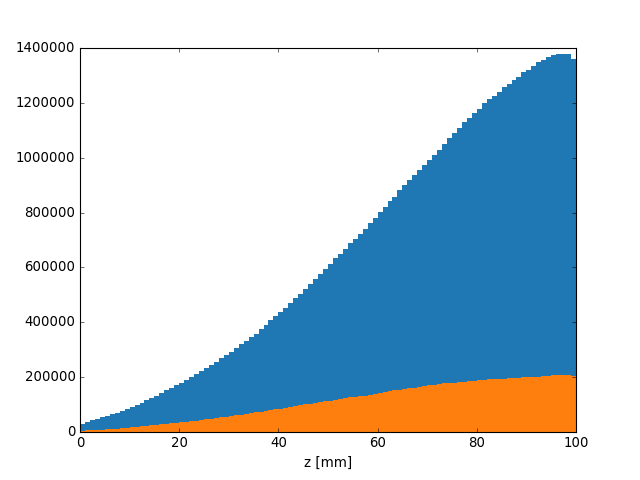

In [8]:
bn = 100

plt.close()
plt.figure()
plt.hist(df_LXe['z'], bins=bn, linewidth=0, facecolor = 'tab:blue')
plt.hist(xz['z'], bins=bn, linewidth=0, facecolor = 'tab:orange')
plt.xlabel('z [mm]')
plt.show()

# Window Plots

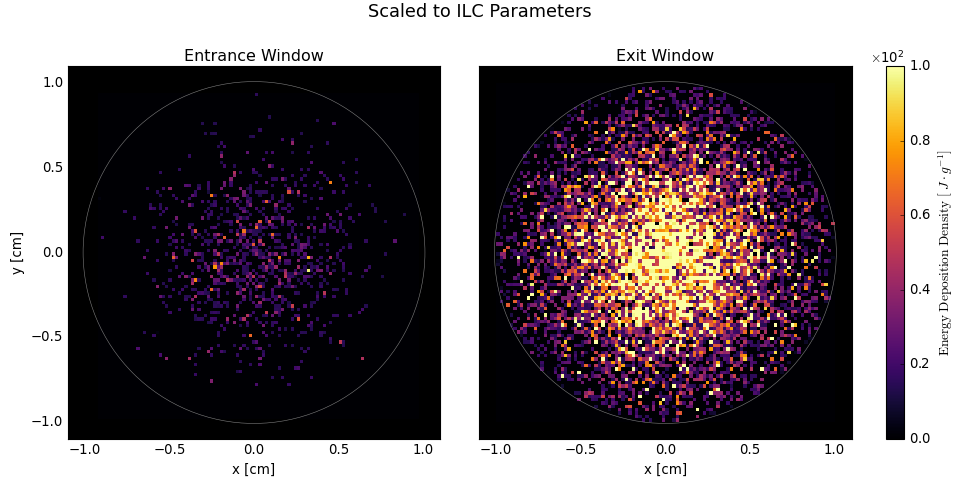

In [7]:
from matplotlib.patches import Circle

WinKey = 'edd' # edep or edd


names = ['Entrance Window', 'Exit Window']
labels = {'edep': r'$E_{dep}\ \left[\mathrm{MeV}\right]$', 'edd': r'$\mathrm{Energy\ Deposition\ Density}\ \left[\ J\cdot g^{-1}\right]$'}
WinEdep = [
    df_EntranceWin,
    df_ExitWin
    ]

vmin = 0
vmax = {'edep': 10, 'edd': 1e2}
n = 100 # n by n grid

bin_vol = (2*info["WinProperties"]["r_window"]/n)**2 * info["WinProperties"]["Win_thickness"] # cm^3
bin_mass = bin_vol * info["rho"][WinMat] # g
mass = {'edep': 1, 'edd': bin_mass / (1e6 * e_charge)}

WinEDD = []

plt.close()
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12,6), constrained_layout=True)
plt.suptitle('Scaled to ILC Parameters\n', fontsize=16)
for i in range(2):
    # Bin the Edep data to prepare for pcolormesh
    h = np.histogram2d(
        x=WinEdep[i]['x']/10,
        y=WinEdep[i]['y']/10,
        weights=WinEdep[i]['Edep'],
        bins=n,
    )
    
    ################################################
    
    x_edges = h[1]
    y_edges = h[2]

    x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_bin_centers = (y_edges[:-1] + y_edges[1:]) / 2

    Edep_per_bin = h[0]

    # Extract Edep, convert MeV to J, divide by mass of bin
    EDD = Edep_per_bin / mass[WinKey] * ILC_scale # J/g
    
    im = ax[i].pcolormesh(x_edges, y_edges, EDD.T,
        cmap='inferno',
        vmin=vmin,
        vmax=vmax[WinKey], # need to set these, otherwise the left subplot does not obey the colorbar
    )


    if WinKey != 'edd':
        EDD = Edep_per_bin / mass['edd']
    WinEDD.append([ x_edges, y_edges, EDD.T, x_bin_centers, y_bin_centers ])


    ######################################

    # outline the window edges, with a slight fudge factor to endsure we aren't excluding any hits in the EDD calculations later on
    circ = ax[i].add_patch(Circle((0,0), radius=info["WinProperties"]["r_window"] + 1e-2, facecolor='None', edgecolor='gray', lw=0.5))

    ######################################
    
    # ax[i].autoscale_view()
    ax[i].set_xlabel('x [cm]')
    # ax[i].set_xticks(np.arange(-1,1.25,0.25))
    # ax[i].set_yticks(np.arange(-1,1.25,0.25))
    ax[i].set_xlim(-1.1,1.1)
    ax[i].set_title(names[i])
    ax[i].set_aspect('equal')
    ax[i].set_facecolor('black')
ax[0].set_ylabel('y [cm]')
ax[0].set_ylim(-1.1,1.1)
cb = plt.colorbar(im, ax=ax[1], label=labels[WinKey])
cb.formatter.set_useMathText(True)
cb.formatter.set_powerlimits((0, 0))

plt.show()

# Check beam $\sigma_{x,y}$ upon entrance

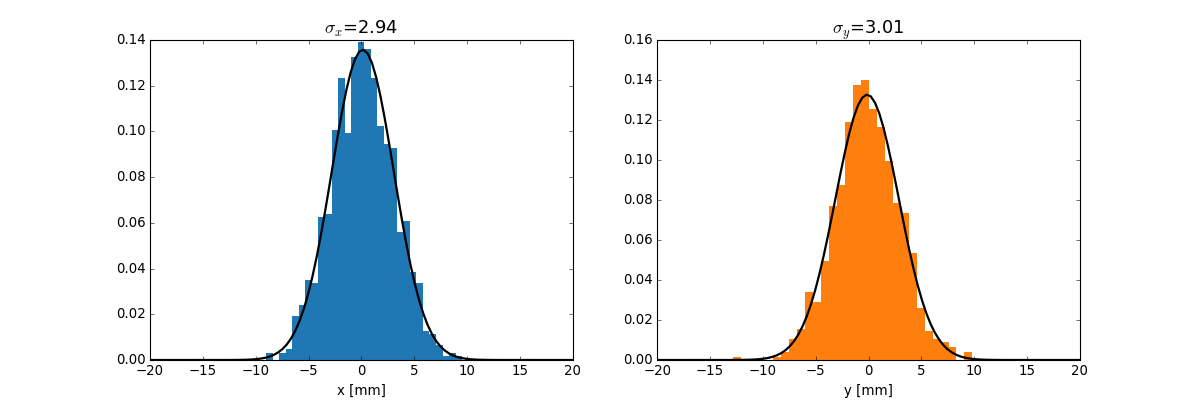

In [9]:
from scipy.stats import norm

# df = df_LXe
# df = df_EntranceWin
# df = df_ExitWin
df = pd.read_csv(path+'/EntranceWinDet.txt', skiprows=3, names='x y z Px Py Pz t PDGid EventID TrackID ParentID Weight'.split(' '), delim_whitespace=True).drop(index=0)

df = df[(df['PDGid'] == 11) & (np.sqrt(df['x']**2 + df['y']**2) < 20)]

# r = np.sqrt(df['x']**2 + df['y']**2)

fitX = np.linspace(-20, 20, 100)
# fitR = np.linspace(0, 10, 100)

muX, stdX = norm.fit(df['x'])
muY, stdY = norm.fit(df['y'])

# muR, stdR = norm.fit(r)

pX = norm.pdf(fitX, muX, stdX)
pY = norm.pdf(fitX, muY, stdY)

# pR = norm.pdf(fitR, muR, stdR)

plt.close()
fig, ax = plt.subplots(1, 2, figsize=(15,5))
# plt.hist(r, facecolor = 'tab:blue', linewidth = 0)
h = ax[0].hist(df['x'], facecolor = 'tab:blue', bins = 30, linewidth = 0, density=True)
ax[0].plot(fitX, pX, 'k', linewidth=2)
ax[0].set_xlabel('x [mm]')
ax[0].set_title(r'$\sigma_x$=' + f'{stdX:.2f}', fontsize=16)

h = ax[1].hist(df['y'], facecolor = 'tab:orange', bins = 30, linewidth = 0, density=True)
ax[1].plot(fitX, pY, 'k', linewidth=2)
ax[1].set_xlabel('y [mm]')
ax[1].set_title(r'$\sigma_y$=' + f'{stdY:.2f}', fontsize=16)

plt.show()

# print(np.sqrt(stdX**2 + stdY**2))

# plt.close()
# plt.figure()
# plt.hist(r, facecolor = 'tab:red', bins = 30, linewidth = 0, density=True)
# plt.plot(fitR, pR, 'k', linewidth=2)
# plt.xlabel('r [mm]')
# plt.show()

# LXe $E_{\mathrm{dep}}$ Plots

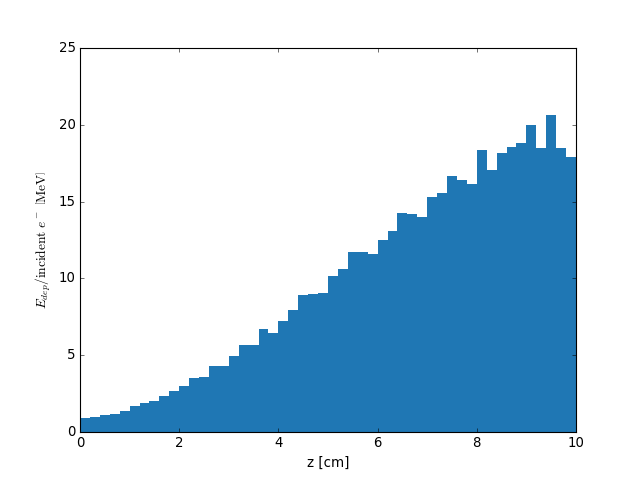

In [17]:
plt.close()
plt.figure()
plt.hist(x=df_LXe['z']/10, weights=df_LXe['Edep']/n_events, bins=50, facecolor = 'tab:blue', linewidth=0)
plt.xlabel('z [cm]')
plt.ylabel(r'$E_{dep}/\mathrm{incident}\ e^-\ \left[\mathrm{MeV}\right]$')
plt.show()

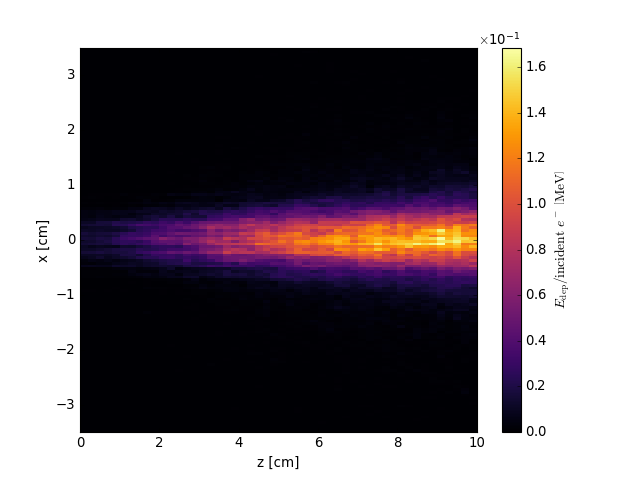

In [8]:
plt.close()
plt.figure()
plt.hist2d(x=xz['z']/10, y=xz['x']/10, weights=xz['Edep']/n_events, bins=[50, 140], cmap='inferno')
plt.xlabel('z [cm]')
plt.ylabel('x [cm]')
cb = plt.colorbar(label=r'$E_{\mathrm{dep}}/\mathrm{incident}\ e^-\ \left[\mathrm{MeV}\right]$')
cb.formatter.set_useMathText(True)
cb.formatter.set_powerlimits((0, 0))
# plt.gca().set_aspect(aspect=info["LXeDim"][0]/info["LXeDim"][1])
plt.show()

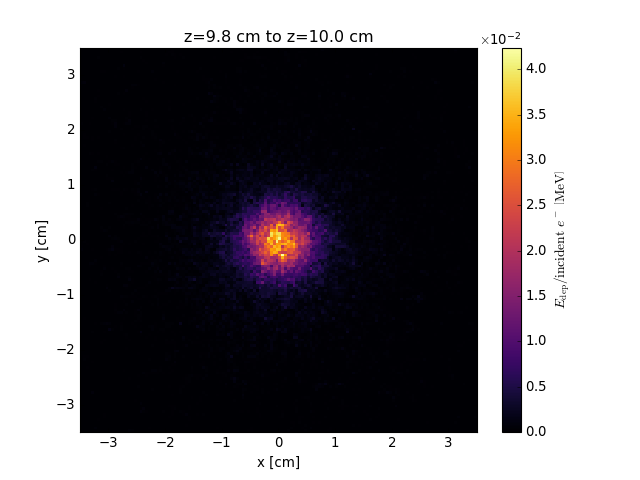

In [9]:
plt.close()
plt.figure()
plt.hist2d(x=xy['x']/10, y=xy['y']/10, weights=xy['Edep']/n_events, bins=140, cmap='inferno')
# plt.hist2d(x=xy['x']/10, y=xy['y']/10, weights=xy['Edep']/n_events, bins=1000, cmap='inferno', vmax=5e-4)
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.title(f'z={(z_pos-eps/2)/10} cm to z={(z_pos+eps/2)/10} cm')
cb = plt.colorbar(label=r'$E_{\mathrm{dep}}/\mathrm{incident}\ e^-\ \left[\mathrm{MeV}\right]$')
cb.formatter.set_useMathText(True)
cb.formatter.set_powerlimits((0, 0))
plt.show()

# LXe Energy Deposition Density Plots

In [10]:
xz_bins=[50,35]
xz_EDD = calculate_EDD(projection='y', bins=xz_bins, mask=True)

n = 100
xy_bins=[n, n]
xy_EDD = calculate_EDD(projection='z', bins=xy_bins, mask=True)

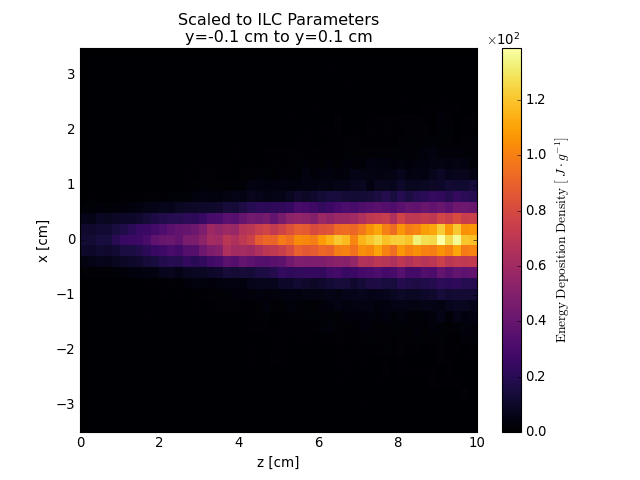

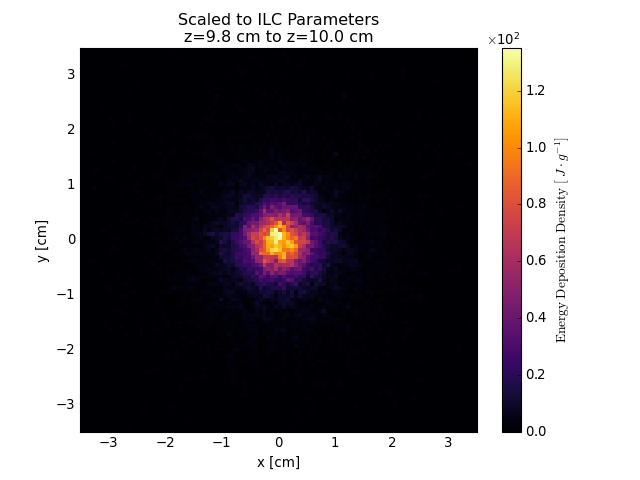

In [11]:
plt.close()
plt.figure()
plt.pcolormesh(xz_EDD[0], xz_EDD[1], xz_EDD[2] * ILC_scale, cmap='inferno')
plt.xlabel(r'z [cm]')
plt.ylabel(r'x [cm]')
plt.title(f'Scaled to ILC Parameters\ny={(-eps/2)/10} cm to y={(eps/2)/10} cm')
plt.xlim(0,info["LXeDim"][2])
plt.ylim(-info["LXeDim"][0]/2,info["LXeDim"][0]/2)
cb = plt.colorbar(label=r'$\mathrm{Energy\ Deposition\ Density}\ \left[\ J\cdot g^{-1}\right]$')
cb.formatter.set_useMathText(True)
cb.formatter.set_powerlimits((0, 0))
plt.show()

plt.close()
plt.figure()
plt.pcolormesh(xy_EDD[0], xy_EDD[1], xy_EDD[2] * ILC_scale, cmap='inferno')
plt.xlabel(r'x [cm]')
plt.ylabel(r'y [cm]')
plt.xlim(-info["LXeDim"][0]/2,info["LXeDim"][0]/2)
plt.ylim(-info["LXeDim"][1]/2,info["LXeDim"][1]/2)
plt.title(f'Scaled to ILC Parameters\nz={(z_pos-eps/2)/10} cm to z={(z_pos+eps/2)/10} cm')
cb = plt.colorbar(label=r'$\mathrm{Energy\ Deposition\ Density}\ \left[\ J\cdot g^{-1}\right]$')
cb.formatter.set_useMathText(True)
cb.formatter.set_powerlimits((0, 0))
plt.show()

# Print Energy Deposition Density Information

Re-calculate EDD without slices

In [8]:
xz_bins=[50,35]
xz_EDD = calculate_EDD(projection='y', bins=xz_bins, mask=False)

n = 100
xy_bins=[n, n]
xy_EDD = calculate_EDD(projection='z', bins=xy_bins, mask=False)

In [9]:
print(xz_EDD[2].mean() * ILC_scale)
print(xz_EDD[2][xz_EDD[2]>0].mean() * ILC_scale)
print(xy_EDD[2][np.sqrt(xy_EDD[4]**2 + xy_EDD[3]**2) <= 0.6].mean() * ILC_scale)
print(xz_EDD[2].max() * ILC_scale)
print(f'\nAdjusted to old assumption of 6 mm radius cylinder for operating volume: {df_LXe["Edep"].sum() * 1e6 * e_charge * ILC_scale / (0.6**2 * np.pi * info["LXeDim"][2] * info["rho"]["LXe"]):.2f} J/g')

1.7454714095546082
1.751476471743443
9.097061916478339
20.235874729114723

Adjusted to old assumption of 6 mm radius cylinder for operating volume: 75.62 J/g


In [10]:
main_dep_radius = 1.0 + 1e-3 # cm
xz_mask = xz_EDD[4] <= main_dep_radius
xy_mask = np.sqrt(xy_EDD[4]**2 + xy_EDD[3]**2) <= main_dep_radius
win_mask = [np.sqrt(WinEDD[i][4]**2 + WinEDD[i][3]**2) <= info["WinProperties"]["r_window"] + 1e-2 for i in range(2)]

# print(f'\n######### Mean EDD/incident e- #########\n\nLXe:\t{xz_EDD[2].mean() / n_events:.2e} J/g')
# print(f'Entrance Window: {WinEDD[0][2][win_mask[0]].mean() / n_events:.2e} J/g\nExit Window:\t{WinEDD[1][2][win_mask[1]].mean() / n_events:.2e} J/g\n')

print(f'\n######### The following is scaled for ILC parameters: {n_bunches} bunches @ {n_incident:.1e} e- per bunch  #########')

print(f'\n######### Mean EDD #########\n\nLXe:\t{xz_EDD[2].mean() * ILC_scale:.2f} J/g')
print(f'Entrance Window: {WinEDD[0][2][win_mask[0]].mean():.2f} J/g\nExit Window:\t{WinEDD[1][2][win_mask[1]].mean():.2f} J/g\n')

# print(f'\n######### Mean EDD/{n_events:.0f} e- (excluding zeros) #########\n\nLXe:\t{xz_EDD[2][xz_EDD[2] > 0].mean():.2e} J/g')

# print(f'\n######### Mean EDD #########\n(particles within 1.001 cm of beam axis)\n\nLXe:\t{xy_EDD[2][xy_mask].mean() * ILC_scale:.2e} J/g')

print(f'\n######### Max EDD #########\n\nLXe:\t{xz_EDD[2].max() * ILC_scale:.2f} J/g')
print(f'Entrance Window: {WinEDD[0][2][win_mask[0]].max():.2f} J/g\nExit Window:\t{WinEDD[1][2][win_mask[1]].max():.2f} J/g\n')


############## Bulk info below ##############

LXe_mass = info["LXeDim"][0]*info["LXeDim"][1]*info["LXeDim"][2] * info["rho"]["LXe"] # 

# print(bin_vol) # volume of tub from other version is 0.0054 cm^3

# Bulk values are smaller since you divide by entire mass of the solid.
print(f'\n######### Bulk Edep #########\n\nEdep/ILC Train')
print(f'Entrance Window: {df_EntranceWin["Edep"].sum() * 1e6 * e_charge * ILC_scale:.2f} J\nExit Window:\t{df_ExitWin["Edep"].sum() * 1e6 * e_charge * ILC_scale:.2f} J\n')

print(f'\n######### Bulk EDD #########\n\nLXe:\t{df_LXe["Edep"].sum() * 1e6 * e_charge / LXe_mass * ILC_scale:.2f} J/g') # This matches the mean EDD in detector cubes from other type of LXe partition with cubes
print(f'Entrance Window: {df_EntranceWin["Edep"].sum() * 1e6 * e_charge / WinMass * ILC_scale:.2f} J/g\nExit Window:\t{df_ExitWin["Edep"].sum() * 1e6 * e_charge / WinMass * ILC_scale:.2f} J/g\n') # One order of magnitude smaller than tub parition of windows


######### The following is scaled for ILC parameters: 1312 bunches @ 2.5e+10 e- per bunch  #########

######### Mean EDD #########

LXe:	1.75 J/g
Entrance Window: 2.51 J/g
Exit Window:	36.11 J/g


######### Max EDD #########

LXe:	20.24 J/g
Entrance Window: 95.95 J/g
Exit Window:	1113.30 J/g


######### Bulk Edep #########

Edep/ILC Train
Entrance Window: 0.71 J
Exit Window:	10.22 J


######### Bulk EDD #########

LXe:	1.75 J/g
Entrance Window: 2.43 J/g
Exit Window:	35.20 J/g



In [11]:
percent_dep = 0.5 # expected percentage of energy deposited in window

print(f'{percent_dep/100 * 3e9 * e_charge * n_incident * n_bunches:.2f} J')
print(f'{percent_dep/100 * 3e9 * e_charge * n_incident * n_bunches / WinMass:.2f} J/g')

78.83 J
271.55 J/g


# Bin LXe Data

In [12]:
# Loop over slices of LXe to create partitioned 3D data

# Redefine slice stuff
zbin = 50 # desired number of bins/divisions in z
n_transverse = 70 # number of bins/divisions in x and y
z_eps = info["LXeDim"][2]/zbin * 10 # width of z-slice of LXe in mm

edep_data = np.zeros((zbin, n_transverse, n_transverse))
# coordinate_data = np.zeros((50, 3, n_transverse))
# z_coord = np.zeros(zbin)

# Define bin edges for x and y (assumes they have the same dimension)
step = info["LXeDim"][0]/n_transverse
xy_edges = np.arange(-info["LXeDim"][0]/2, info["LXeDim"][0]/2+step, step)
xy_bin_centers = (xy_edges[:-1] + xy_edges[1:]) / 2
z_centers = np.arange(z_eps/20, info["LXeDim"][2]+z_eps/20, z_eps/10)

X,Y,Z = np.meshgrid(xy_bin_centers, xy_bin_centers, z_centers)
# X,Y = np.meshgrid(xy_bin_centers, xy_bin_centers)

# with open("LXe_binned.txt", "w") as f:
    # f.write("x\ty\tz\tedep")
for i in range(zbin):
    z_loc = z_eps*(i+1/2) # z-coordinate of (center of) slice mm
    if i != zbin-1:
        z_mask = ((df_LXe['z'] >= z_loc - z_eps/2) & (df_LXe['z'] < z_loc + z_eps/2))
    else:
        # Handle the edge case
        z_mask = ((df_LXe['z'] >= z_loc - z_eps/2) & (df_LXe['z'] <= z_loc + z_eps/2))

    df = df_LXe[z_mask]

    h = np.histogram2d(
        x=df['x']/10, # cm
        y=df['y']/10, # cm
        weights=df['Edep'], # MeV
        bins=xy_edges,
    )

    # Note that `ILC_scale` also accounts for n_events, i.e., number of incident e- in the simulation
    edep_data[i] = h[0].T * ILC_scale # MeV (transposed due to the weirdness of numpy histogram2d)
    
edep_data = edep_data.T # transpose final edep dataset to match shape of meshgrid elements

In [13]:
print(f'Reference Dimensions: x={step} cm, y={step} cm, z={z_eps/10} cm\nReference Volume: {z_eps/10 * step**2:.2e} cm^3')

Reference Dimensions: x=0.1 cm, y=0.1 cm, z=0.2 cm
Reference Volume: 2.00e-03 cm^3


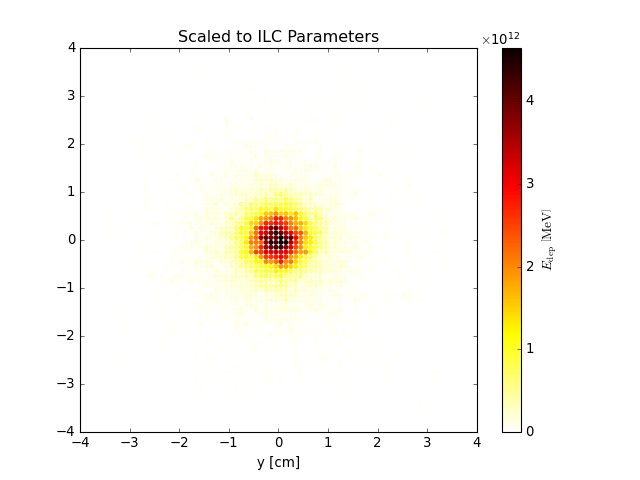

In [14]:
idx = -1

plt.close()
plt.figure()
plt.scatter(X[:,:,idx].ravel(),Y[:,:,idx].ravel(), c=edep_data[:,:,idx].ravel(), cmap='hot_r', edgecolors='none')
cb = plt.colorbar(label=r'$E_{\mathrm{dep}}\ \left[\mathrm{MeV}\right]$')
cb.formatter.set_useMathText(True)
cb.formatter.set_powerlimits((0, 0))
plt.title('Scaled to ILC Parameters')
plt.xlabel('x [cm]')
plt.xlabel('y [cm]')
plt.show()

# 3D Plot of $E_{\textrm{dep}}$

Define custom colormap to handle points with zero $E_{\textrm{dep}}$

In [40]:
def customCMAP(names = ['hot_r'], ncolors: int = 256):

        for cmap in names:
            # if custom version of cmap already exists, skip it
            if cmap + 'T' in plt.colormaps():
                continue
            else:
            # create the colormap
                color_array = plt.get_cmap(cmap)(range(ncolors))
                color_array[:,-1] = np.power(np.linspace(0, 1.0, ncolors), 1/2) # adjusted so that the alpha increases quicker than linearly
                map_object = mcolors.LinearSegmentedColormap.from_list(name = cmap + 'T', colors = color_array)
                plt.register_cmap(cmap = map_object)

customCMAP()


3D plot of $E_{\textrm{dep}}$ in LXe (adjusted to ILC parameters)

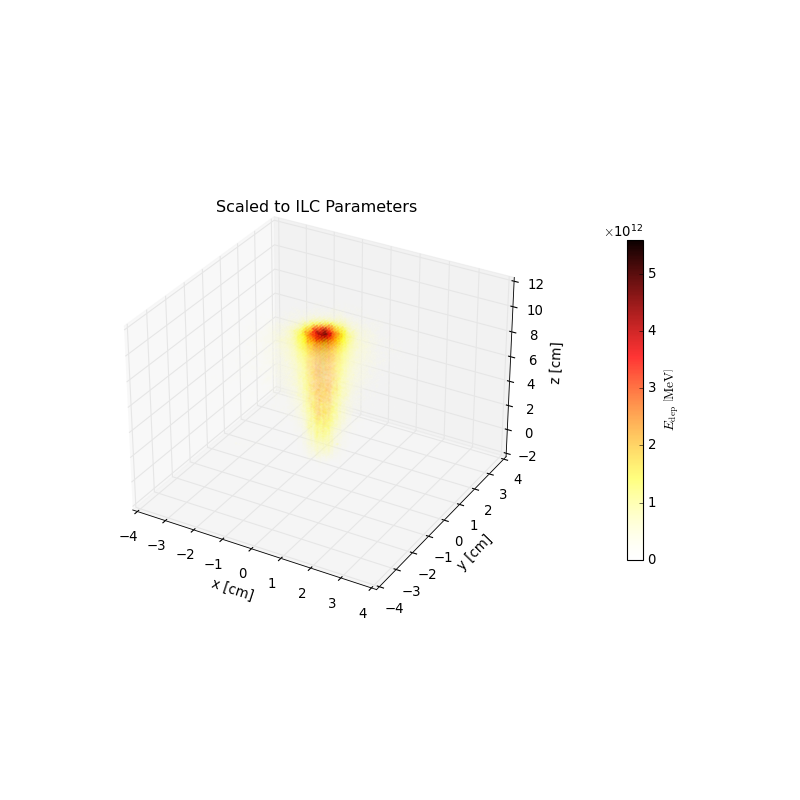

In [273]:
plt.close()
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
img = ax.scatter(X.ravel(), Y.ravel(), Z.ravel(), c=edep_data.ravel(), marker='o', s=5, cmap='hot_rT', edgecolors='none')
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('z [cm]')
# ax.set_title()
ax.set_title('Scaled to ILC Parameters')
cb = fig.colorbar(img, ax=ax, label=r'$E_{\mathrm{dep}}\ \left[\mathrm{MeV}\right]$', pad=0.15, shrink=.5)
cb.formatter.set_useMathText(True)
cb.formatter.set_powerlimits((0, 0))
plt.show()

# Plot and format window data

3D plots of $E_{\textrm{dep}}$ in windows (adjusted to ILC parameters)

In [37]:
WinEdep = [
    df_EntranceWin,
    df_ExitWin
    ]

n = 100 # n by n grid

window_edep_data = np.zeros(2, dtype=object)

# Define bin edges for x and y (assumes they have the same dimension)
step = 2*info["WinProperties"]["r_window"]/n # cm
xy_edges = np.arange(-info["WinProperties"]["r_window"], info["WinProperties"]["r_window"]+step, step)
xy_bin_centers = (xy_edges[:-1] + xy_edges[1:]) / 2
zcenter_entrance = -info["WinProperties"]["Win_thickness"]/2 * np.ones(n*n) # cm
zcenter_exit = info["LXeDim"][-1]+info["WinProperties"]["Win_thickness"]/2 * np.ones(n*n) # cm

bin_vol = (2*info["WinProperties"]["r_window"]/n)**2 * info["WinProperties"]["Win_thickness"] # cm^3
bin_mass = bin_vol * info["rho"][WinMat] # g

X_window,Y_window = np.meshgrid(xy_bin_centers, xy_bin_centers)
X_window,Y_window = np.meshgrid(xy_bin_centers, xy_bin_centers)

for i in range(2):
    # Bin the Edep data to prepare for export
    h = np.histogram2d(
        x=WinEdep[i]['x']/10,
        y=WinEdep[i]['y']/10,
        weights=WinEdep[i]['Edep'], # MeV
        bins=xy_edges,
    )
    
    # Note that `ILC_scale` also accounts for n_events, i.e., number of incident e- in the simulation
    window_edep_data[i] = h[0].T * ILC_scale # MeV (transposed due to the weirdness of numpy histogram2d)
    
window_edep_data = window_edep_data.T # transpose final edep dataset to match shape of meshgrid elements

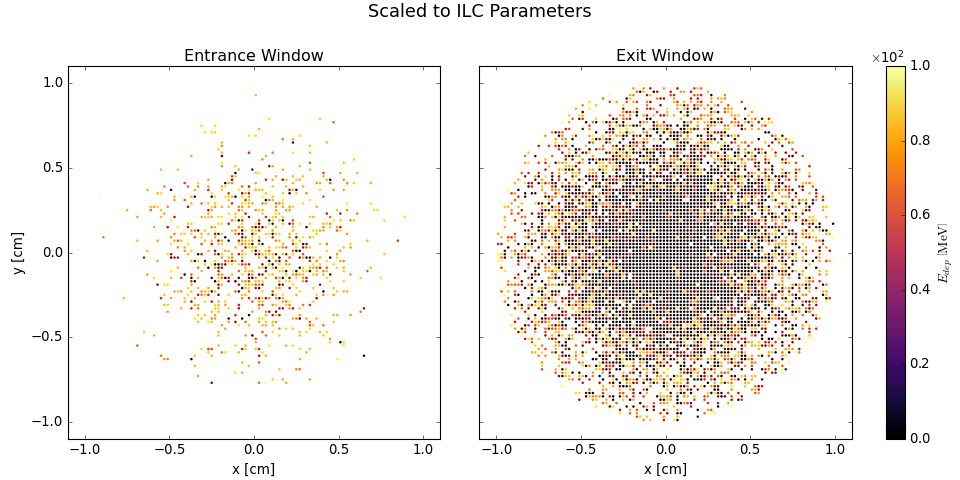

In [61]:
vmin = 0
vmax = 1e10

plt.close()
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12,6), constrained_layout=True)
plt.suptitle('Scaled to ILC Parameters\n', fontsize=16)
for i in range(2):
    ax[i].scatter(X_window.ravel(), Y_window.ravel(), c=window_edep_data[i].ravel(), marker='o', s=5, cmap='hot_r', edgecolors='none', vmin=vmin, vmax=vmax)
    ax[i].set_xlabel('x [cm]')
    ax[i].set_xlim(-1.1,1.1)
    ax[i].set_title(names[i])
    ax[i].set_aspect('equal')
ax[0].set_ylabel('y [cm]')
ax[0].set_ylim(-1.1,1.1)
cb = plt.colorbar(im, ax=ax[1], label=r'$E_{dep}\ \left[\mathrm{MeV}\right]$')
cb.formatter.set_useMathText(True)
cb.formatter.set_powerlimits((0, 0))

plt.show()

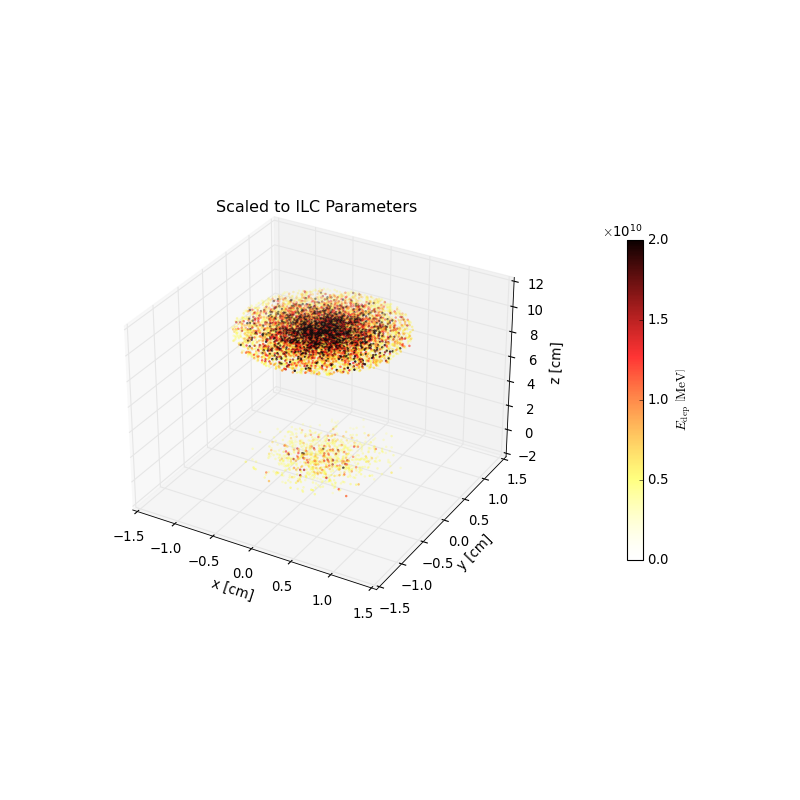

In [47]:
vmin = 0
vmax = 2e10

plt.close()
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
img = ax.scatter(X_window.ravel(), Y_window.ravel(), zcenter_entrance, c=window_edep_data[0].ravel(), marker='o', s=5, cmap='hot_rT', edgecolors='none', vmin=vmin, vmax=vmax)
ax.scatter(X_window.ravel(), Y_window.ravel(), zcenter_exit, c=window_edep_data[1].ravel(), marker='o', s=5, cmap='hot_rT', edgecolors='none', vmin=vmin, vmax=vmax)
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('z [cm]')
# ax.set_title()
ax.set_title('Scaled to ILC Parameters')
cb = fig.colorbar(img, ax=ax, label=r'$E_{\mathrm{dep}}\ \left[\mathrm{MeV}\right]$', pad=0.15, shrink=.5)
cb.formatter.set_useMathText(True)
cb.formatter.set_powerlimits((0, 0))
plt.show()

# Write binned LXe data to CSV

In [247]:
export_dict = {
    'x': X.ravel(),
    'y': Y.ravel(),
    'z': Z.ravel(),
    'Edep': edep_data.ravel(),
}

export_df = pd.DataFrame(export_dict)

export_df.to_csv(path+"/LXe_export.csv", index=False)

# Test Plots

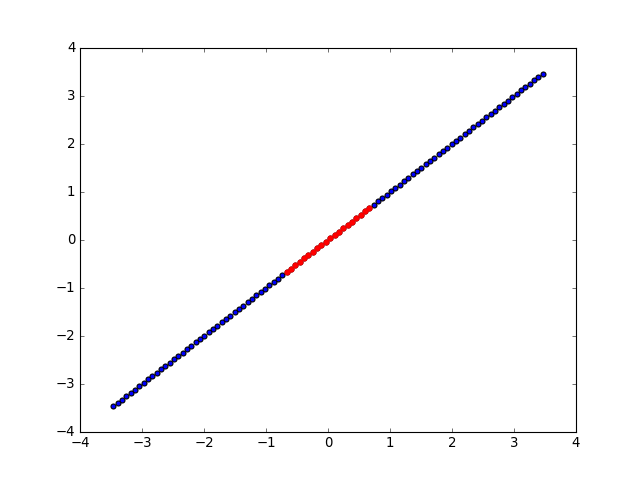

In [45]:
plt.close()
plt.figure()
plt.scatter(xy_EDD[3], xy_EDD[4])
plt.scatter(xy_EDD[3][xy_mask], xy_EDD[4][xy_mask], color='r')
plt.show()

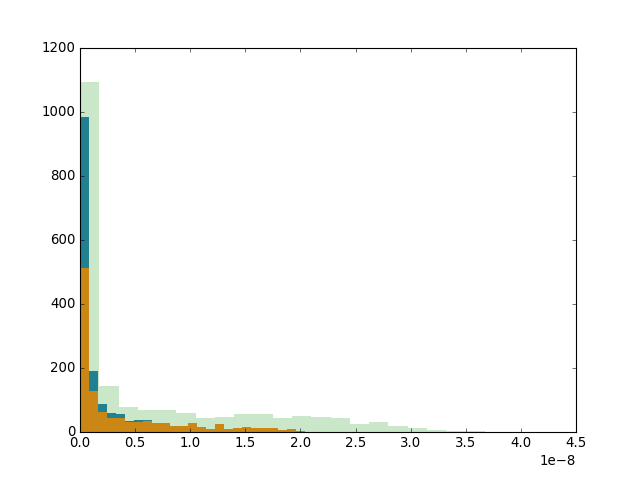

In [46]:
plt.close()
plt.figure()
plt.hist(xz_EDD[2].flatten(), bins=25, linewidth=0, facecolor='tab:blue')
plt.hist(xz_EDD[2][xz_mask].flatten(), bins=25, linewidth=0, facecolor='tab:orange')
plt.hist(xy_EDD[2][xy_mask].flatten(), bins=25, linewidth=0, facecolor='tab:green', alpha = .25)
plt.show()